# Cargamos la librería

In [6]:
import numpy as np
import pandas as pd 

# importar archivos
import os
import glob


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.python.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from IPython.display import Image

In [7]:

Dataset= 'C:/Users/naira/OneDrive/Documentos/Máster Data Science/TFM/dataset imágenes/human face/dataset/'
Val = 'C:/Users/naira/OneDrive/Documentos/Máster Data Science/TFM/dataset imágenes/human face/validate/'


# Modelo con Data Augmetation

## Preprocesado 

### Redimensión de las imágenes

In [8]:
import glob
import os
from PIL import Image
def preprocesado_imagen(dataset_dir, tamaño):
   for filename in glob.glob(dataset_dir + "***/*.*"):
        if filename.lower().endswith((".jpg",".jpeg",".png")):
        
                with Image.open(filename) as img:

                     #Convertimos a RGB
                    if img.mode in  ("P","LA"):
                           img = img.convert("RGB")

                     #Redimensionamos la imagen
                    img_resized = img.resize(tamaño)

                    # Guardamos los cambios
                    img_resized.save(filename)


In [9]:
#dataset_dir = Dataset
#tamaño = (32,32)
#preprocesado_imagen(dataset_dir, tamaño)

### Construcción del modelo

In [10]:
from PIL import Image
X = []
y = []
image_size = (32, 32)  # Tamaño común para las imágenes

for filename in glob.glob(Dataset + "***/*.*"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            
            with Image.open(filename) as img:
                img = img.convert('RGB')  # Convertir todas las imágenes a RGB
                img_resized = img.resize(image_size)
                img_array = np.array(img_resized)
                X.append(img_array)
                
                if "FAKE" in filename:
                    y.append(0)
                else:
                    y.append(1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((77411, 32, 32, 3), (77411,), (19353, 32, 32, 3), (19353,))

#### Observamos el balance de los datos 

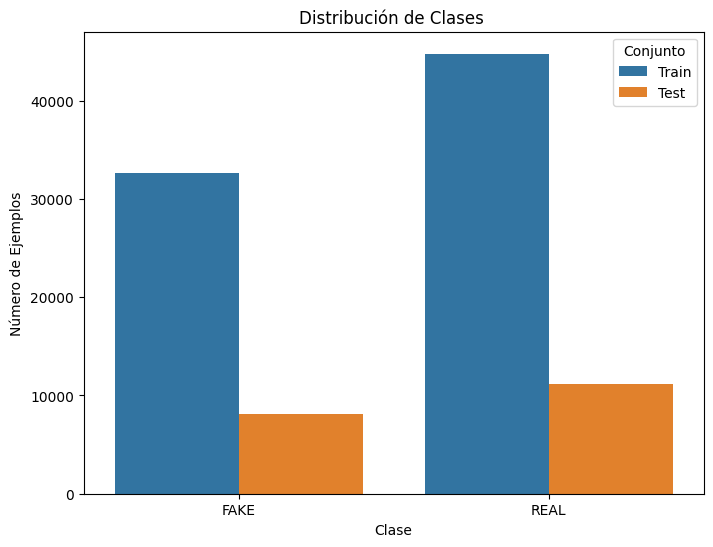

In [13]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)
categories = ['FAKE', 'REAL']

# Crear listas para las etiquetas de las clases y sus respectivos conteos
classes = categories  # Suponiendo que categories = ['REAL', 'FAKE']
train_values = [train_counts[i] for i in range(len(classes))]
test_values = [test_counts[i] for i in range(len(classes))]

# Crear un DataFrame para facilitar la visualización con seaborn
import pandas as pd

df = pd.DataFrame({
    'Clase': classes * 2,
    'Número de ejemplos': train_values + test_values,
    'Conjunto': ['Train'] * len(classes) + ['Test'] * len(classes)
})

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Clase', y='Número de ejemplos', hue='Conjunto', data=df)
plt.title('Distribución de Clases ')
plt.xlabel('Clase')
plt.ylabel('Número de Ejemplos')
plt.show()

Como los datos no están balanceados, relizamos data augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1.0/255.0,             
    rotation_range=20,             
    width_shift_range=0.2,         
    height_shift_range=0.2,        
    shear_range=0.2,               
    zoom_range=0.2,               
    horizontal_flip=True,         
    fill_mode='nearest'            
)

train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

Construimos el modelo

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_it, validation_data=test_it, epochs=50)

Epoch 1/50


c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.5870 - loss: 1.0057 - val_accuracy: 0.6329 - val_loss: 0.6466
Epoch 2/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.6558 - loss: 0.6333 - val_accuracy: 0.6916 - val_loss: 0.5979
Epoch 3/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 89s 74ms/step - accuracy: 0.6813 - loss: 0.6068 - val_accuracy: 0.6852 - val_loss: 0.6013
Epoch 4/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - accuracy: 0.6906 - loss: 0.5957 - val_accuracy: 0.6838 - val_loss: 0.6039
Epoch 5/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 65s 53ms/step - accuracy: 0.7049 - loss: 0.5813 - val_accuracy: 0.7151 - val_loss: 0.5701
Epoch 6/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.7111 - loss: 0.5728 - val_accuracy: 0.7210 - val_loss: 0.5602
Epoch 7/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 94s 78ms/step - accuracy: 0.7221 - loss: 0.5603 - val_accuracy: 0.7189 - val_loss: 0.5616
Epoch 8/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.7227 - loss: 0.55

## Evaluamos el modelo 

Preprocesado 

In [18]:
dataset_dir = Val
tamaño = (32,32)
preprocesado_imagen(dataset_dir, tamaño)

In [19]:
X = []
y = []
image_size = (32, 32)  # Tamaño común para las imágenes

for filename in glob.glob(Val + "***/*.*"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            
            with Image.open(filename) as img:
                img = img.convert('RGB')  # Convertir todas las imágenes a RGB
                img_resized = img.resize(image_size)
                img_array = np.array(img_resized)
                X.append(img_array)
                
                if "FAKE" in filename:
                    y.append(0)
                else:
                    y.append(1)

In [20]:
X_val = np.array(X)
y_val = np.array(y)

In [21]:
X_val.shape, y_val.shape

((24190, 32, 32, 3), (24190,))

Graficamos 

C:\Users\naira\AppData\Local\Temp\ipykernel_58660\739581554.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Número de Ejemplos', data=df, palette='viridis')


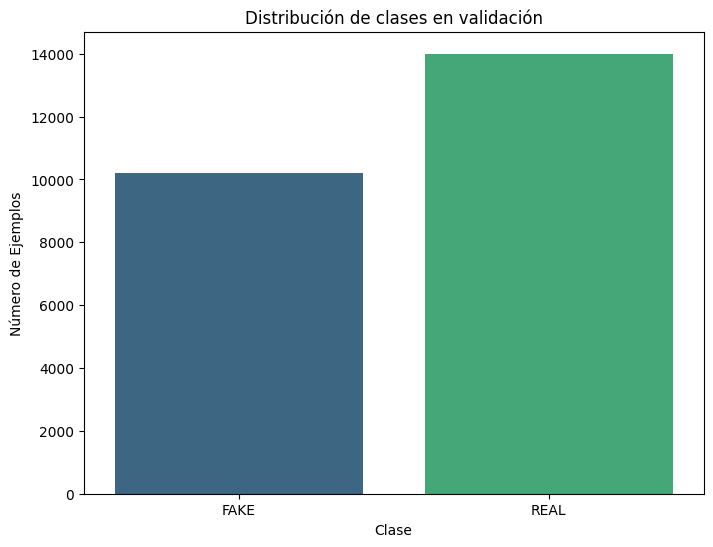

In [22]:
unique, counts = np.unique(y_val, return_counts=True)
class_counts = dict(zip(unique, counts))

# Crear listas para las etiquetas de las clases y sus respectivos conteos
labels = ['FAKE', 'REAL']  # Etiquetas de las clases
val_counts = [class_counts.get(i, 0) for i in range(len(labels))]
df = pd.DataFrame({
    'Clase': labels,
    'Número de Ejemplos': val_counts
})

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Clase', y='Número de Ejemplos', data=df, palette='viridis')
plt.title('Distribución de clases en validación')
plt.xlabel('Clase')
plt.ylabel('Número de Ejemplos')
plt.show()

Reescalamos

In [23]:
datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_it = datagen.flow(X_val, y_val, batch_size=64)


### Evaluamos el modelo

In [24]:
_, acc = model.evaluate(val_it)
print('> %.3f' % (acc * 100.0))

 19/378 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7632 - loss: 0.4855 

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7793 - loss: 0.4698
> 78.078


756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


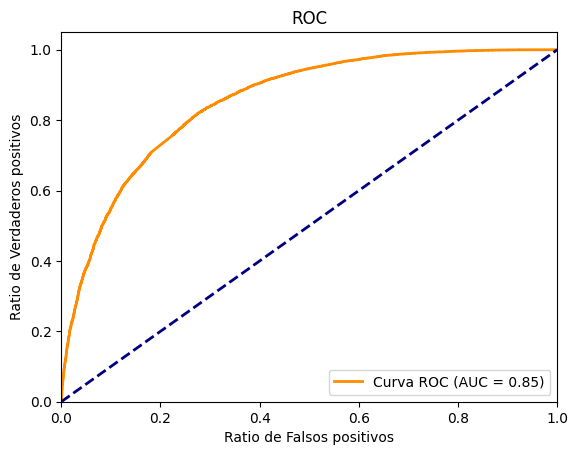

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_val_escalado = X_val*(1/255)
y_pred_prob = model.predict(X_val_escalado)  

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)  


roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Falsos positivos')
plt.ylabel('Ratio de Verdaderos positivos')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [26]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

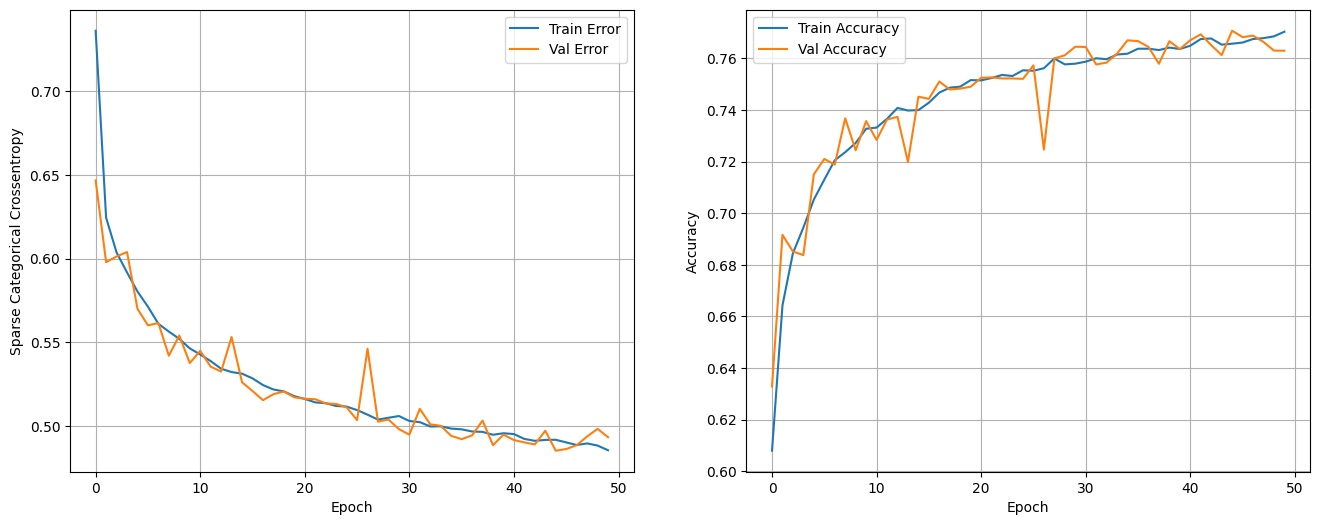

In [27]:
show_loss_accuracy_evolution(history)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, x_test, y_test):
    # Realizar predicciones
    X_test_escalado = x_test*(1/255)
    y_pred = model.predict(X_test_escalado)
    y_pred_classes = (y_pred > 0.5).astype(int) 
    
    # Calcular métricas
    cm = confusion_matrix(y_test, y_pred_classes)
    report = classification_report(y_test, y_pred_classes, target_names=['IA', 'REAL'])
    
    print("Reporte de Clasificación:\n", report)
    
    # Mostrar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['IA', 'REAL'], yticklabels=['IA', 'REAL'])
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderas')
    plt.title('Matriz de Confusión')
    plt.show()


756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
Reporte de Clasificación:
               precision    recall  f1-score   support

          IA       0.76      0.70      0.73     10190
        REAL       0.79      0.84      0.82     14000

    accuracy                           0.78     24190
   macro avg       0.78      0.77      0.77     24190
weighted avg       0.78      0.78      0.78     24190



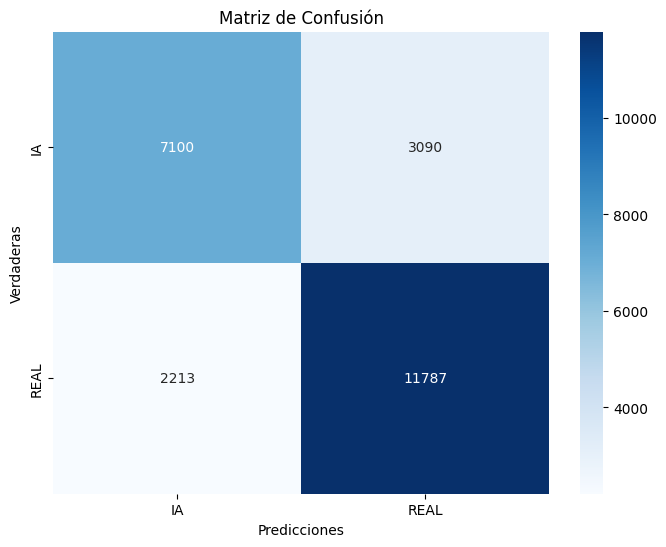

In [29]:
evaluate_model(model,X_val, y_val)

Predecimos 

In [30]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(img_path):

    # Cargar la imagen y redimensionar a 32x32
    image1 = Image.open(img_path)
    image1 = image1.resize((32, 32))  # Redimensionar la imagen a 32x32 píxeles
    img_ar = np.asarray(image1)
    img_ar_rs = img_ar / 255.0  # Normalizar la imagen
    img_ar_rs1 = img_ar_rs.reshape(-1, 32, 32, 3)  # Redimensionar la imagen al tamaño esperado por el modelo

    # Realizar la predicción
    pred = model.predict(img_ar_rs1)

    # Interpretar la predicción
    if pred > 0.5:
        print("La imagen está generada por IA.")
    else:
        print("La imagen es Real.")

In [31]:
predict("C:/Users/naira/OneDrive/Imágenes/Granada.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
La imagen está generada por IA.


In [36]:
predict("C:/Users/naira/OneDrive/Documentos/Máster Data Science/TFM/dataset imágenes/human face/dataset/FAKE/00c219e7956c82608c69c80655d8240525d175eb3fb44492c8bf10f06f5417e9.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
La imagen está generada por IA.


# Modelo con Early Stopping 

In [32]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))  
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128,(3, 3), padding='same', activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())
model1.add(layers.Dropout(0.3)) 

model1.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu'))  
model1.add(layers.Dense(1, activation='sigmoid'))

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,
    verbose = 1)

history =model1.fit(
    train_it,
    epochs=50, 
    validation_data=(test_it),
    callbacks=[early_stopping] )

Epoch 1/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 137s 105ms/step - accuracy: 0.5902 - loss: 0.8887 - val_accuracy: 0.6405 - val_loss: 0.6361
Epoch 2/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 101s 83ms/step - accuracy: 0.6650 - loss: 0.6208 - val_accuracy: 0.6870 - val_loss: 0.6005
Epoch 3/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 99s 81ms/step - accuracy: 0.6862 - loss: 0.5989 - val_accuracy: 0.6968 - val_loss: 0.5831
Epoch 4/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 90s 74ms/step - accuracy: 0.7012 - loss: 0.5803 - val_accuracy: 0.7203 - val_loss: 0.5615
Epoch 5/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 110s 91ms/step - accuracy: 0.7120 - loss: 0.5673 - val_accuracy: 0.7178 - val_loss: 0.5580
Epoch 6/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0.7220 - loss: 0.5548 - val_accuracy: 0.7208 - val_loss: 0.5563
Epoch 7/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 110s 91ms/step - accuracy: 0.7275 - loss: 0.5473 - val_accuracy: 0.7267 - val_loss: 0.5432
Epoch 8/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0

In [37]:
_, acc = model1.evaluate(val_it)
print('> %.3f' % (acc * 100.0))

378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7742 - loss: 0.4883
> 77.367


# Modelo Sin Data Augmentation

## Preprocesado

In [39]:
from PIL import Image
X = []
y = []
image_size = (32, 32)  # Tamaño común para las imágenes

for filename in glob.glob(Dataset + "***/*.*"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            
            with Image.open(filename) as img:
                img = img.convert('RGB')  # Convertir todas las imágenes a RGB
                img_resized = img.resize(image_size)
                img_array = np.array(img_resized)
                X.append(img_array)
                
                if "FAKE" in filename:
                    y.append(0)
                else:
                    y.append(1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((77411, 32, 32, 3), (77411,), (19353, 32, 32, 3), (19353,))

In [42]:
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1.0/255.0)
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

## Construimos el modelo

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
history = model3.fit(train_it, validation_data=test_it, epochs=50)

Epoch 1/50
   3/1210 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5226 - loss: 4.0455

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.6595 - loss: 0.9582 - val_accuracy: 0.7572 - val_loss: 0.5290
Epoch 2/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7630 - loss: 0.5121 - val_accuracy: 0.7889 - val_loss: 0.4734
Epoch 3/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7864 - loss: 0.4734 - val_accuracy: 0.7990 - val_loss: 0.4485
Epoch 4/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8034 - loss: 0.4487 - val_accuracy: 0.8041 - val_loss: 0.4394
Epoch 5/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.8154 - loss: 0.4232 - val_accuracy: 0.8199 - val_loss: 0.4147
Epoch 6/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8295 - loss: 0.4014 - val_accuracy: 0.8276 - val_loss: 0.4058
Epoch 7/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8348 - loss: 0.3892 - val_accuracy: 0.8310 - val_loss: 0.3919
Epoch 8/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8432 - loss: 0.37

## Evaluación

In [47]:
X = []
y = []
image_size = (32, 32)  # Tamaño común para las imágenes

for filename in glob.glob(Val + "***/*.*"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            
            with Image.open(filename) as img:
                img = img.convert('RGB')  # Convertir todas las imágenes a RGB
                img_resized = img.resize(image_size)
                img_array = np.array(img_resized)
                X.append(img_array)
                
                if "FAKE" in filename:
                    y.append(0)
                else:
                    y.append(1)

In [48]:
X_val = np.array(X)
y_val = np.array(y)

In [49]:
datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_it = datagen.flow(X_val, y_val, batch_size=64)

In [50]:
_, acc = model3.evaluate(val_it)
print('> %.3f' % (acc * 100.0))

 10/378 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8387 - loss: 0.4582

c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8470 - loss: 0.4250
> 84.523


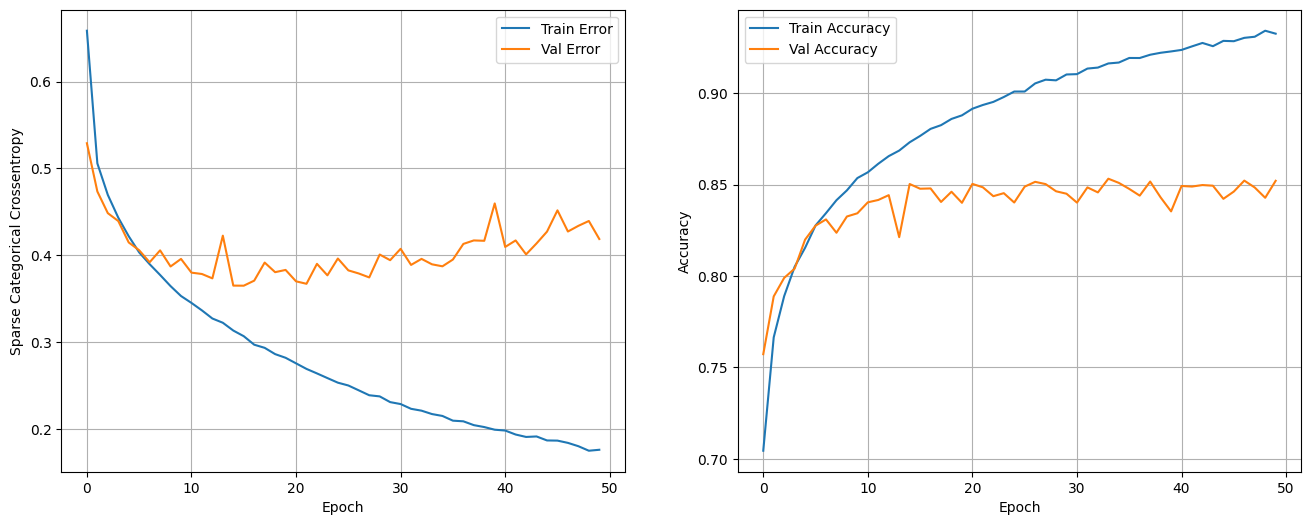

In [51]:
show_loss_accuracy_evolution(history)

Curva Roc

756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


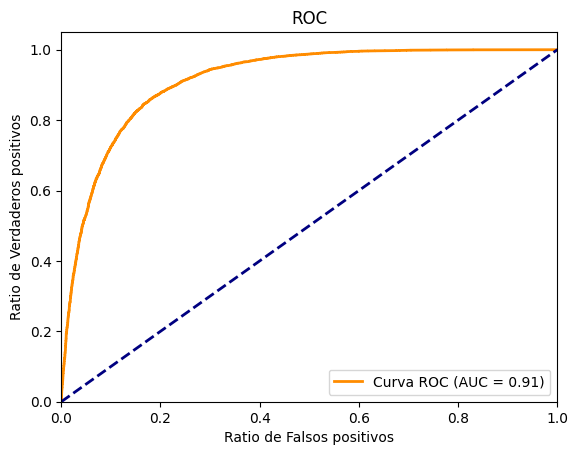

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_val_escalado = X_val*(1/255)
y_pred_prob = model3.predict(X_val_escalado)  

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)  


roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Falsos positivos')
plt.ylabel('Ratio de Verdaderos positivos')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Reporte de Clasificación:
               precision    recall  f1-score   support

          IA       0.84      0.78      0.81     10190
        REAL       0.85      0.89      0.87     14000

    accuracy                           0.85     24190
   macro avg       0.84      0.84      0.84     24190
weighted avg       0.84      0.85      0.84     24190



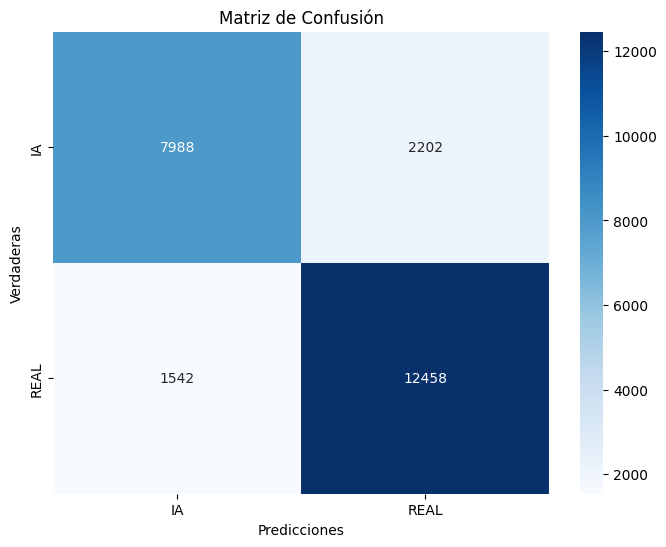

In [53]:
evaluate_model(model3,X_val, y_val)

# Transfer Learning

In [54]:
image_size = (32,32,3)
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size, include_top=False)
pretrained_model.trainable = True

C:\Users\naira\AppData\Local\Temp\ipykernel_58660\1902825540.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size, include_top=False)


In [55]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [56]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten()(x)
flat = tf.keras.layers.Dropout(0.5)(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flat)

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [57]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 20

import numpy as np
from sklearn.utils import class_weight

# Calcula las ponderaciones de las clases
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # La opción 'balanced' calcula las ponderaciones automáticamente.
    classes=np.unique(y_train),  # Las clases en tus datos.
    y=y_train  # El vector de etiquetas.
)

# Convierte el array de pesos a un diccionario para usarlo en el entrenamiento
class_weights_dict = dict(enumerate(class_weights))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=2,  
    verbose=1)

history = model_tl.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=epochs,
)

Epoch 1/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 1055s 241ms/step - accuracy: 0.6407 - loss: 0.7248 - val_accuracy: 0.5743 - val_loss: 0.7097
Epoch 2/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 440s 182ms/step - accuracy: 0.5934 - loss: 0.6983 - val_accuracy: 0.6591 - val_loss: 0.7438
Epoch 3/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 520s 215ms/step - accuracy: 0.6541 - loss: 0.6490 - val_accuracy: 0.6239 - val_loss: 0.8688
Epoch 4/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 525s 217ms/step - accuracy: 0.6380 - loss: 0.6660 - val_accuracy: 0.5846 - val_loss: 0.8378
Epoch 5/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 466s 192ms/step - accuracy: 0.5938 - loss: 0.6983 - val_accuracy: 0.5686 - val_loss: 0.7041
Epoch 6/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 396s 164ms/step - accuracy: 0.5794 - loss: 0.6982 - val_accuracy: 0.4120 - val_loss: 0.7766
Epoch 7/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 483s 200ms/step - accuracy: 0.6151 - loss: 0.6828 - val_accuracy: 0.4996 - val_loss: 0.7503
Epoch 8/20
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 495s 204ms/step - a

In [58]:
results = model_tl.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

605/605 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6321 - loss: 0.6561
Test Loss: 0.6589978337287903
Test Accuracy: 0.6304965615272522


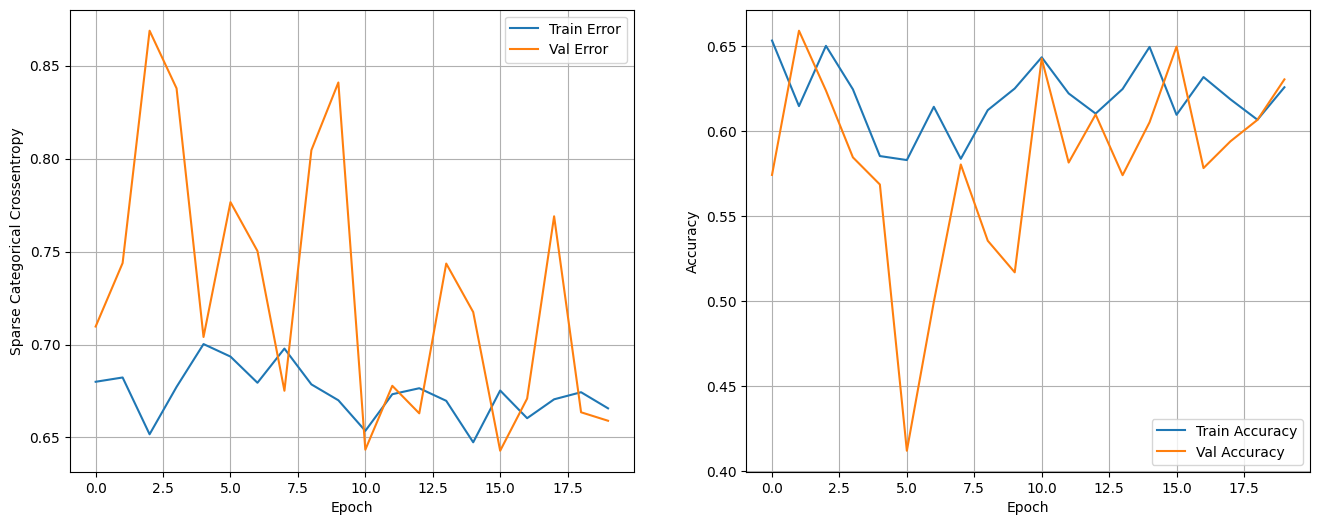

In [59]:
show_loss_accuracy_evolution(history)

756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step


c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\naira\anaconda3\envs\modelo1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Reporte de Clasificación:
               precision    recall  f1-score   support

          IA       0.42      1.00      0.59     10190
        REAL       0.00      0.00      0.00     14000

    accuracy                           0.42     24190
   macro avg       0.21      0.50      0.30     24190
weighted avg       0.18      0.42      0.25     24190



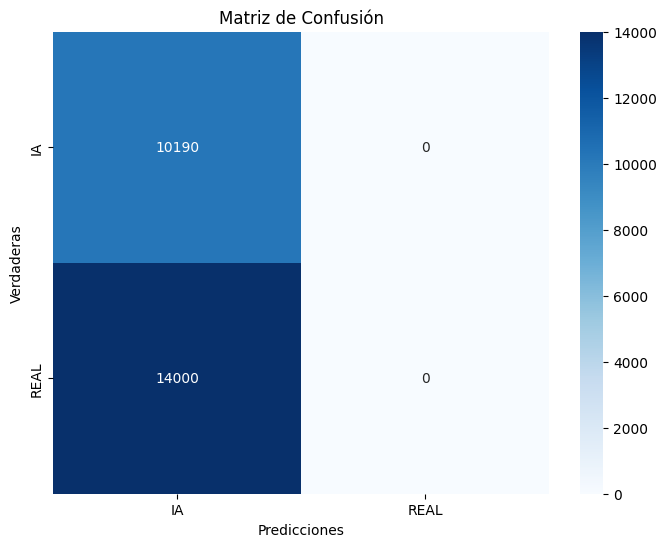

In [60]:
evaluate_model(model_tl,X_val, y_val)

756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


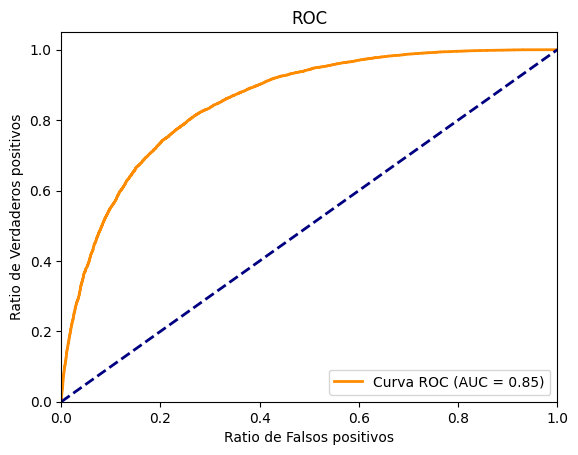

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_val_escalado = X_val*(1/255)
y_pred_prob = model1.predict(X_val_escalado)  

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)  


roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Falsos positivos')
plt.ylabel('Ratio de Verdaderos positivos')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()